**STOCK MARKET PREDICTION USING NUMERICAL AND TEXTUAL ANALYSIS**

BHARADWAJ

**vvs.bharadwaj2000@gmail.com**

**https://www.linkedin.com/in/bharadwaj-vvs-9ba679132/**

https://github.com/bharat070/STOCK_MARKET_PREDICTION

Date: 11-09-2022

Datasets used:


*   Historical Stock Prices: https://finance.yahoo.com/
*   Textual News Headlines: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH



In [1]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

**DOWNLOADING DATA AND READING DATA**

In [5]:
from google.colab import files
upload = files.upload
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
stock_price = pd.read_csv('/content/drive/MyDrive/Sparks foundation/AAPL.csv')
stock_headlines = pd.read_csv('/content/drive/MyDrive/Sparks foundation/india-news-headlines.csv')

In [7]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200


In [8]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


**2.0 FEATURE ENGINEERING**

In [9]:
len(stock_price), len(stock_headlines)

(4904, 3650970)

In [10]:
stock_price.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [11]:
stock_headlines.isna().any()

publish_date         False
headline_category    False
headline_text        False
dtype: bool

**2.1 STOCK PRICE DATA**

In [12]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price.head()

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200


**2.2 STOCK NEWS HEADLINES DATA**

In [13]:
stock_headlines = stock_headlines.drop_duplicates()

In [14]:
# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

In [15]:
# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


**2.3 COMBINED STOCK DATA**

In [16]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2020-06-24,90.014999,91.250000,92.197502,89.629997,192623200.0,I never thought I had a voice until today: Vid...
2020-06-25,91.209999,90.175003,91.250000,89.392502,137522400.0,Truck firms look for new export markets to sel...
2020-06-26,88.407501,91.102501,91.330002,88.254997,205256800.0,Containment zone residents slam high prices ch...
2020-06-29,90.445000,88.312500,90.542503,87.820000,130646000.0,6 hot and stylish bikini looks of Katrina Kaif...


**2.4 SENTIMENT ANALYSIS**

In [17]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...,,,,
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [19]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [20]:
# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [21]:
# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [22]:
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])

In [23]:
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

In [24]:
# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,0.265625,0.265625,0.272321,0.260045,452312000.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,0.292411,0.258929,0.297991,0.257813,817073600.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,0.304688,0.323940,0.330357,0.300223,739396000.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.080
2001-01-05,0.292411,0.302455,0.310268,0.286830,412356000.0,Light combat craft takes India into club class...,0.9253,0.104,0.744,0.152
2001-01-08,0.295759,0.302455,0.303292,0.284598,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026


**3.0 WRITING TO DISK**

In [25]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9253,0.104,0.744,0.152,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0


In [26]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

**4.0 READING STOCK DATA**

In [27]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9253,0.104,0.744,0.152,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0


**5.0 Feature Engineering of STOCK DATA**

In [28]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(4876, 9)

In [29]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [30]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4876.000000,4.876000e+03
mean,17.240855,-0.868015,0.126728,0.786119,0.087148,17.231561,17.406451,17.060156,4.512664e+08
std,18.701517,0.457865,0.024262,0.033028,0.020960,18.671171,18.873885,18.500307,3.855541e+08
min,0.234286,-1.000000,0.000000,0.000000,0.000000,0.231964,0.235536,0.227143,3.247000e+07
25%,2.134196,-0.999800,0.113000,0.766000,0.076000,2.137232,2.173392,2.097143,1.774491e+08
50%,10.928036,-0.999100,0.128000,0.782000,0.087000,10.909285,11.007143,10.769642,3.374560e+08
75%,27.350625,-0.994200,0.142000,0.804000,0.097000,27.336249,27.606875,27.106250,6.050912e+08
max,91.632500,1.000000,0.444000,1.000000,0.608000,91.250000,93.095001,90.567497,3.372970e+09


In [31]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4876 entries, 2001-01-02 to 2020-06-30
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4876 non-null   float64
 1   compound  4876 non-null   float64
 2   negative  4876 non-null   float64
 3   neutral   4876 non-null   float64
 4   positive  4876 non-null   float64
 5   Open      4876 non-null   float64
 6   High      4876 non-null   float64
 7   Low       4876 non-null   float64
 8   Volume    4876 non-null   float64
dtypes: float64(9)
memory usage: 380.9+ KB


**6.0 EDA OF STOCK DATA**

Text(0, 0.5, 'Close Price ($)')

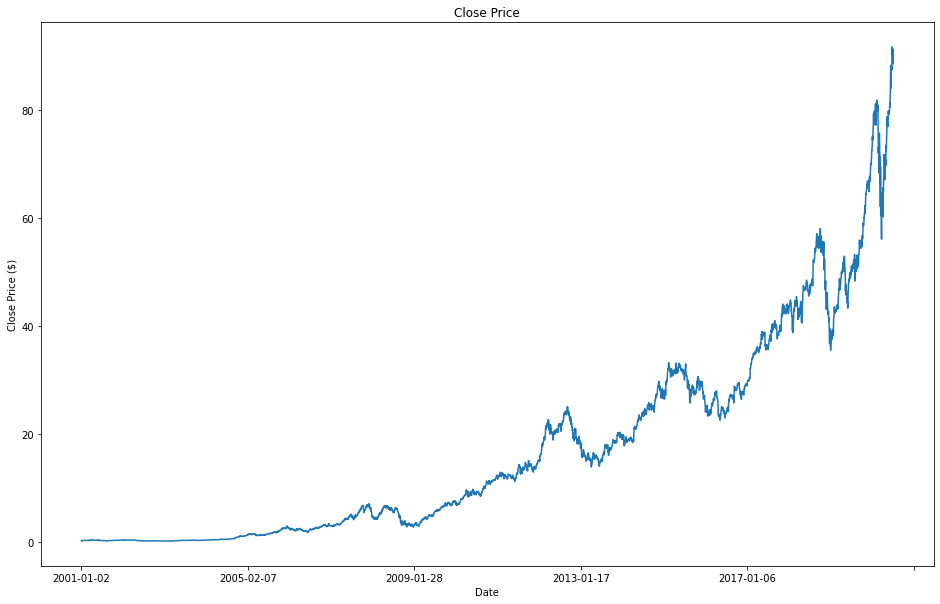

In [32]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [33]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,0.293368,-0.175914,0.121571,0.810143,0.068000,0.293088,0.304687,0.281728,566364000.0
2001-01-23,0.307717,0.094314,0.109714,0.818286,0.071714,0.304408,0.319196,0.293208,627395200.0
2001-01-24,0.318240,-0.125129,0.111429,0.825000,0.063429,0.320033,0.329400,0.306282,613112000.0


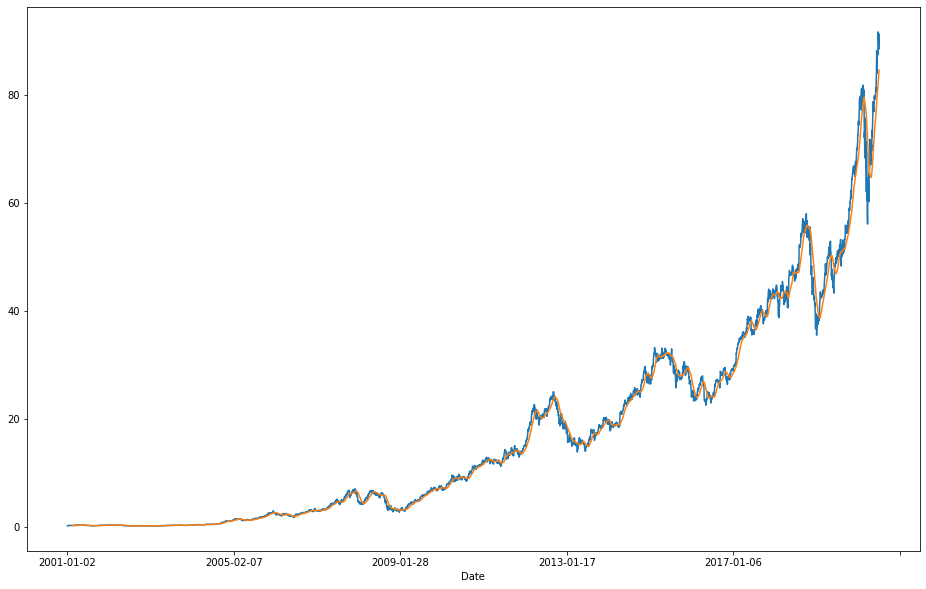

In [34]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [35]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,0.265625,-0.9621,0.119,0.817,0.064,0.265625,0.272321,0.260045,452312000.0
2001-01-03,0.292411,0.6322,0.084,0.817,0.098,0.258929,0.297991,0.257813,817073600.0
2001-01-04,0.304688,0.6648,0.077,0.843,0.080,0.323940,0.330357,0.300223,739396000.0
2001-01-05,0.292411,0.9253,0.104,0.744,0.152,0.302455,0.310268,0.286830,412356000.0
2001-01-08,0.295759,-0.9638,0.119,0.855,0.026,0.302455,0.303292,0.284598,373699200.0
...,...,...,...,...,...,...,...,...,...
2020-06-24,90.014999,-0.9997,0.116,0.808,0.075,91.250000,92.197502,89.629997,192623200.0
2020-06-25,91.209999,-0.9999,0.130,0.816,0.054,90.175003,91.250000,89.392502,137522400.0
2020-06-26,88.407501,-0.9999,0.150,0.765,0.085,91.102501,91.330002,88.254997,205256800.0


**7.0 DATA PREP FOR MODELLING**

In [36]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3900
Number of records in Test Data: 976


In [37]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-01-03     0.292411
2001-01-04     0.304688
2001-01-05     0.292411
2001-01-08     0.295759
2001-01-09     0.306920
                ...    
2020-06-24    90.014999
2020-06-25    91.209999
2020-06-26    88.407501
2020-06-29    90.445000
2020-06-30    91.199997
Name: Close, Length: 4875, dtype: float64

In [38]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-01-03,0.292411,0.304688,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.292411,0.6648,0.9253,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.295759,0.9253,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,0.306920,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,0.295759,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
2001-01-10,0.295759,0.366071,-0.5719,0.9295,580781600.0,0.297991,0.303571,0.286830
2001-01-23,0.366071,0.366071,0.9295,-0.9039,879530400.0,0.344866,0.373884,0.340402
2001-01-24,0.366071,0.356027,-0.9039,-0.9838,717091200.0,0.368304,0.369420,0.349330
2001-01-25,0.356027,0.349330,-0.9838,0.8926,489708800.0,0.367188,0.367188,0.352679


**8.0 SETTING THE VARIABLE AND THE FEATURE DATASET**

In [39]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2001-01-03     0.304688
2001-01-04     0.292411
2001-01-05     0.295759
2001-01-08     0.306920
2001-01-09     0.295759
                ...    
2020-06-23    90.014999
2020-06-24    91.209999
2020-06-25    88.407501
2020-06-26    90.445000
2020-06-29    91.199997
Name: close_price_shifted, Length: 4874, dtype: float64

In [40]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-01-03,0.292411,0.6322,0.6648,817073600.0,0.258929,0.297991,0.257813
2001-01-04,0.304688,0.6648,0.9253,739396000.0,0.323940,0.330357,0.300223
2001-01-05,0.292411,0.9253,-0.9638,412356000.0,0.302455,0.310268,0.286830
2001-01-08,0.295759,-0.9638,-0.9559,373699200.0,0.302455,0.303292,0.284598
2001-01-09,0.306920,-0.9559,-0.5719,588929600.0,0.300223,0.315011,0.295759
...,...,...,...,...,...,...,...
2020-06-23,91.632500,-0.9999,-0.9997,212155600.0,91.000000,93.095001,90.567497
2020-06-24,90.014999,-0.9997,-0.9999,192623200.0,91.250000,92.197502,89.629997
2020-06-25,91.209999,-0.9999,-0.9999,137522400.0,90.175003,91.250000,89.392502


**8.1 SCALING THE TARGET VARIABLE AND THE FEATURE DATASET**

In [41]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.99872809,  0.6322    ,  0.6648    , ..., -0.99940748,
         -0.99865485, -0.99932101],
        [-0.99845944,  0.6648    ,  0.9253    , ..., -0.99797895,
         -0.99795775, -0.99838212],
        [-0.99872809,  0.9253    , -0.9638    , ..., -0.99845105,
         -0.99839043, -0.99867862],
        ...,
        [ 0.99075472, -0.9999    , -0.9999    , ...,  0.97637837,
          0.96026251,  0.97398737],
        [ 0.92942972, -0.9999    , -0.9997    , ...,  0.99675891,
          0.96198559,  0.94880472],
        [ 0.97401481, -0.9997    , -0.9998    , ...,  0.93545235,
          0.94502449,  0.93917454]]), array([[-0.99845944],
        [-0.99872809],
        [-0.99865483],
        ...,
        [ 0.92942972],
        [ 0.97401481],
        [ 0.99053585]]))

**8.2 DIVIDING THE DATASET INTO TRAINING AND TEST**

In [42]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (3900, 7) and y: (3900, 1)
Number of rows and columns in the Test set X: (973, 7) and y: (973, 1)


**8.3 RESHAPING THE FEATURE DATA**

In [43]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3900, 7, 1)
Shape of Test set X: (973, 7, 1)


**9.0 STOCK DATA MODELLING**

In [44]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [45]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
390/390 [==============================] - 8s 12ms/step - loss: 0.0328 - val_loss: 0.1302
Epoch 2/10
390/390 [==============================] - 3s 8ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 3/10
390/390 [==============================] - 3s 9ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 4/10
390/390 [==============================] - 3s 9ms/step - loss: 0.0019 - val_loss: 3.3572e-04
Epoch 5/10
390/390 [==============================] - 3s 9ms/step - loss: 0.0019 - val_loss: 2.7003e-04
Epoch 6/10
390/390 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 3.2422e-04
Epoch 7/10
390/390 [==============================] - 3s 9ms/step - loss: 0.0014 - val_loss: 3.0200e-04
Epoch 8/10
390/390 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 8.5436e-04
Epoch 9/10
390/390 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/10
390/390 [==============================] - 4s 10ms/step - loss: 0.0

**9.1 SAVING THE MODEL TO DISK**

In [46]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


**10 PREDICTIONS**

In [47]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[26.71828 ],
       [26.805511],
       [26.734867],
       [26.627588],
       [26.688381]], dtype=float32)

**11 MODEL EVALUATION**

In [48]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

973/973 [==============================] - 2s 2ms/step - loss: 0.0018
Train Loss = 0.0005
Test Loss = 0.0018


In [49]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 51.2156


In [50]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 51.2156


**12 PLOTTING THE PREDICTIONS AGAINST UNSEEN DATA**

In [51]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

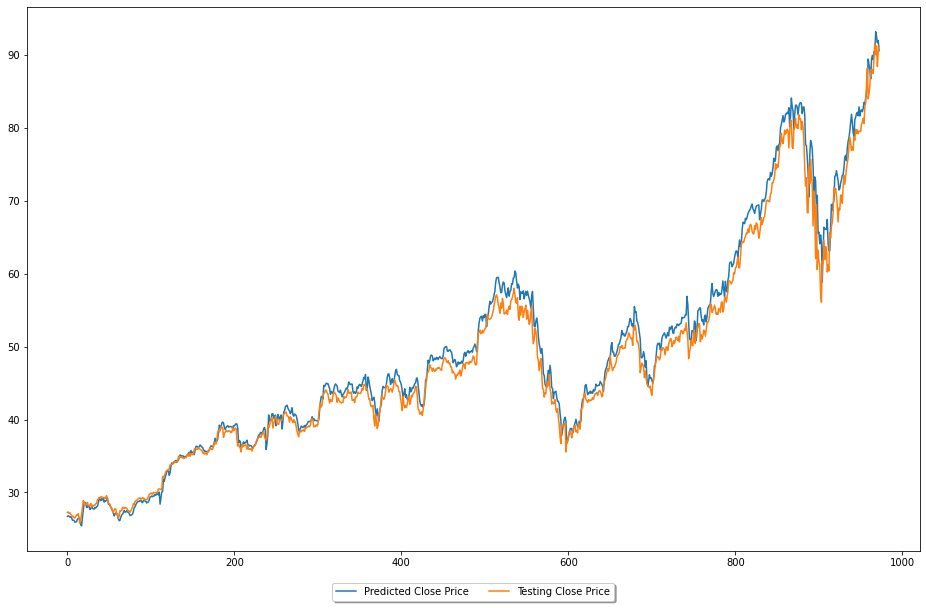

In [52]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

**13 REFERENCES**

1. https://github.com/monica110394/Stock-Market-Prediction
2. https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/